In [34]:
import torch
from openai import OpenAI
from tqdm import tqdm
import pandas as pd
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

### Read the Combined Evaluation Responses along with Question/Answer Pairs for Validation Dataset

In [35]:
with open('response_generation_data/all_model_responses.pkl', 'rb') as file:
    all_model_responses = pickle.load(file)

all_model_responses.head()

,topic,question,answerText,gpt_responses_base,gpt_responses_ft,llama_responses_base,llama_responses_ft
0,relationships,I had to go to the emergency room today to get...,It is extremely frustrating when our significa...,I'm sorry to hear about your experience. It's ...,Be straightforward with how you felt at that s...,It's completely understandable that you're fee...,The only way your boyfriend will see your poin...
1,marriage,What makes a healthy marriage last? What makes...,"This is a fantastic question. In one sentence,...",A healthy and lasting marriage often hinges on...,"What a happy, healthy marriage looks or feels ...",A healthy marriage is built on a foundation of...,There are many different ways to answer this q...
2,relationships,"I'm a female freshman in high school, and this...","First off, I think it is great that you are wi...",It's great that you want to support your frien...,Hi there. It sounds like you care a lot for Ti...,I'm glad you're taking the initiative to suppo...,Hi. I love your thoughtful question! I'm glad ...
3,intimacy,"My wife and I are newly married, about 2 month...","You are newly married, you Have a hectic sched...",Navigating intimacy issues in a new marriage c...,You have most of the knowledge you need alread...,I can sense the frustration and concern in you...,It sounds like you have a lot of emotional int...
4,legal-regulatory,"I think I have depression, anxiety, bipolar di...",It can be difficult to get counseling if you d...,I'm sorry to hear you're going through this. I...,There are a number of resources you can utiliz...,I'm so sorry to hear that you're struggling wi...,"Hi Colorado, I'm sorry to hear that your mom i..."


#### Creating a new dataframe to record the evaluation results

Calculating the word length of the response of each model

In [36]:
df_response_evaluation = pd.DataFrame(all_model_responses['topic'])

In [37]:
df_response_evaluation['gpt_responses_base_len'] = all_model_responses['gpt_responses_base'].apply(lambda x: len(x.split()))
df_response_evaluation['gpt_responses_ft_len'] = all_model_responses['gpt_responses_ft'].apply(lambda x: len(x.split()))
df_response_evaluation['llama_responses_base_len'] = all_model_responses['llama_responses_base'].apply(lambda x: len(x.split()))
df_response_evaluation['llama_responses_ft_len'] = all_model_responses['llama_responses_ft'].apply(lambda x: len(x.split()))
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len
0,relationships,186,175,197,89
1,marriage,211,282,225,573
2,relationships,209,204,333,450
3,intimacy,203,229,325,155
4,legal-regulatory,192,159,207,234


### OpenAI Configuration and Responses

In [38]:
with open("../../api.key", 'r') as file:
    openai_api_key = file.read()

openai_client = OpenAI(api_key=openai_api_key)

In [ ]:
def get_openai_response(system_prompt: str, user_prompt: str) -> str:
        
    completion = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
        ]
    )

    openai_response = completion.choices[0].message.content
    
    return openai_response

### Evaluating the responses by GPT based on CTRS Metrics

In [ ]:
system_prompt_eval = 'You are an expert mental-health counsellor'
user_prompt_eval = '''You are given a conversation between a patient and therapist. Your job is to assess the response of therapist on a scale from 0 to 6 as per each of the following criterion.

<<AGENDA>>
0 = Therapist did not set agenda.
2 = Therapist set agenda that was vague or incomplete.
4 = Therapist worked with patient to set a mutually satisfactory agenda that included specific target problems (e.g., anxiety at work, dissatisfaction with marriage).
6 = Therapist worked with patient to set an appropriate agenda with target problems, suitable for the available time. Established priorities and then followed agenda

<<FEEDBACK>>
0 = Therapist did not ask for feedback to determine patient’s understanding of, or response to, the session.
2 = Therapist elicited some feedback from the patient, but did not ask enough questions to be sure the patient understood the therapist’s line of reasoning during the session or to ascertain whether the patient was satisfied with the session.
4 = Therapist asked enough questions to be sure that the patient understood the therapist’s line of reasoning throughout the session and to determine the patient’s reactions to the session. The therapist adjusted his/her behavior in response to the feedback when appropriate.
6 = Therapist was especially adept at eliciting and responding to verbal and nonverbal feedback throughout the session (e.g., elicited reactions to session, regularly checked for understanding, helped summarize main points at end of session).

<<UNDERSTANDING>>
0 = Therapist repeatedly failed to understand what the patient explicitly said and thus consistently missed the point. Poor empathic skills.
2 = Therapist was usually able to reflect or rephrase what the patient explicitly said, but repeatedly failed to respond to more subtle communication. Limited ability to listen and empathize.
4 = Therapist generally seemed to grasp the patient’s “internal reality” as reflected by both what the patient explicitly said and what the patient communicated in more subtle ways. Good ability to listen and empathize.
6 = Therapist seemed to understand the patient’s “internal reality” thoroughly and was adept at communicating this understanding through appropriate verbal and nonverbal responses to the patient (e.g., the tone of the therapist’s response conveyed a sympathetic understanding of the patient’s “message”). Excellent listening and empathic skills.

<<INTERPERSONAL EFFECTIVENESS>>
0 = Therapist had poor interpersonal skills. Seemed hostile, demeaning, or in some other way destructive to the patient.
2 = Therapist did not seem destructive, but had significant interpersonal problems. At times, therapist appeared unnecessarily impatient, aloof, insincere or had difficulty conveying confidence and competence.
4 = Therapist displayed a satisfactory degree of warmth, concern, confidence, genuineness, and professionalism. No significant interpersonal problems.
6 = Therapist displayed optimal levels of warmth, concern, confidence, genuineness, and professionalism, appropriate for this particular patient in this session.

<<COLLABORATION>>
0 = Therapist did not attempt to collaborate with patient.
2 = Therapist attempted to collaborate with patient, but had difficulty either defining a problem that the patient considered important or establishing rapport.
4 = Therapist was able to collaborate with patient, focus on a problem that both patient and therapist considered important, and establish rapport.
6 = Collaboration seemed excellent; therapist encouraged patient as much as possible to take an active role during the session (e.g., by offering choices) so they could function as a “team.”

<<PACING AND EFFICIENT USE OF TIME>>
0 = Therapist made no attempt to structure therapy time. Session seemed aimless.
2 = Session had some direction, but the therapist had significant problems with structuring or pacing (e.g., too little structure, inflexible about structure, too slowly paced, too rapidly paced).
4 = Therapist was reasonably successful at using time efficiently. Therapist maintained appropriate control over flow of discussion and pacing.
6 = Therapist used time efficiently by tactfully limiting peripheral and unproductive discussion and by pacing the session as rapidly as was appropriate for the patient.

<<GUIDED DISCOVERY>>
0 = Therapist relied primarily on debate, persuasion, or “lecturing.” Therapist seemed to be “cross-examining” patient, putting the patient on the defensive, or forcing his/her point of view on the patient.
2 = Therapist relied too heavily on persuasion and debate, rather than guided discovery. However, therapist’s style was supportive enough that patient did not seem to feel attacked or defensive.
4 = Therapist, for the most part, helped patient see new perspectives through guided discovery (e.g., examining evidence, considering alternatives, weighing advantages and disadvantages) rather than through debate. Used questioning appropriately.
6 = Therapist was especially adept at using guided discovery during the session to explore problems and help patient draw his/ her own conclusions. Achieved an excellent balance between skillful questioning and other modes of intervention.

<<FOCUSING ON KEY COGNITIONS OR BEHAVIORS>>
0 = Therapist did not attempt to elicit specific thoughts, assumptions, images, meanings, or behaviors.
2 = Therapist used appropriate techniques to elicit cognitions or behaviors; however, therapist had difficulty finding a focus or focused on cognitions/behaviors that were irrelevant to the patient’s key problems.
4 = Therapist focused on specific cognitions or behaviors relevant to the target problem. However, therapist could have focused on more central cognitions or behaviors that offered greater promise for progress.
6 = Therapist very skillfully focused on key thoughts, assumptions, behaviors, etc., that were most relevant to the problem area and offered considerable promise for progress.

<<STRATEGY FOR CHANGE>> (Note: For this item, focus on the quality of the therapist’s strategy for change, not on how effectively the strategy was implemented or whether change actually occurred.)
0 = Therapist did not select cognitive-behavioral techniques.
2 = Therapist selected cognitive-behavioral techniques; however, either the overall strategy for bringing about change seemed vague or did not seem promising in helping the patient.
4 = Therapist seemed to have a generally coherent strategy for change that showed reasonable promise and incorporated cognitive-behavioral techniques.
6 = Therapist followed a consistent strategy for change that seemed very promising and incorporated the most appropriate cognitive-behavioral techniques.

<<APPLICATION OF COGNITIVE-BEHAVIORAL TECHNIQUES>> (Note: For this item, focus on how skillfully the techniques were applied, not on how appropriate they were for the target problem or whether change actually occurred.)
0 = Therapist did not apply any cognitive-behavioral techniques.
2 = Therapist used cognitive-behavioral techniques, but there were significant flaws in the way they were applied.
4 = Therapist applied cognitive-behavioral techniques with moderate skill.
6 = Therapist very skillfully and resourcefully employed cognitive-behavioral techniques.

<<HOMEWORK>>
0 = Therapist did not attempt to incorporate homework relevant to cognitive therapy.
2 = Therapist had significant difficulties incorporating homework (e.g., did not review previous homework, did not explain homework in sufficient detail, assigned inappropriate homework).
4 = Therapist reviewed previous homework and assigned “standard” cognitive therapy homework generally relevant to issues dealt with in session. Homework was explained in sufficient detail.
6 = Therapist reviewed previous homework and carefully assigned homework drawn from cognitive therapy for the coming week. Assignment seemed “custom-tailored” to help patient incorporate new perspectives, test hypotheses, experiment with new behaviors discussed during session, etc.

For each criterion, descriptions are provided for even-numbered scale points. If you believe the therapist falls between two of the descriptors, select the intervening odd number (1, 3, 5). For example, if the therapist set a very good agenda but did not establish priorities, assign a rating of a 5 rather than a 4 or 6.

Do not leave any criterion blank. For all criterion, focus on the skill of the therapist, taking into account how difficult the patient seems to be.

You final response must not contain any description about any criterion and it must ONLY be in a json serializable format as following {{
    <<AGENDA>>: <<AGENDA>> rating,
    <<FEEDBACK>>: <<FEEDBACK>> rating,
    <<UNDERSTANDING>>: <<UNDERSTANDING>> rating,
    <<INTERPERSONAL EFFECTIVENESS>>: <<INTERPERSONAL EFFECTIVENESS>> rating,
    <<COLLABORATION>>: <<COLLABORATION>> rating,
    <<PACING AND EFFICIENT USE OF TIME>>: <<PACING AND EFFICIENT USE OF TIME>> rating,
    <<GUIDED DISCOVERY>>: <<GUIDED DISCOVERY>> rating,
    <<FOCUSING ON KEY COGNITIONS OR BEHAVIORS>>: <<FOCUSING ON KEY COGNITIONS OR BEHAVIORS>> rating, 
    <<STRATEGY FOR CHANGE>>: <<STRATEGY FOR CHANGE>> rating,
    <<APPLICATION OF COGNITIVE-BEHAVIORAL TECHNIQUES>>: <<APPLICATION OF COGNITIVE-BEHAVIORAL TECHNIQUES>> rating,
    <<HOMEWORK>>: <<HOMEWORK>> rating
}}

[PATIENT Problem]:
{patient}

[THERAPIST Response]:
{therapist}
'''

#### Evaluating the Original Responses

In [41]:
# original_responses_eval = []

# for index, row in tqdm(all_model_responses.iterrows(), total=len(all_model_responses)):
    
#     patient_problem = row['question']
#     therapist_response = row['answerText'] #Original Response
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     original_responses_eval.append(response_eval)

# with open('response_evaluation_data/original_responses_eval.pkl', 'wb') as file:
#     pickle.dump(original_responses_eval, file)

In [42]:
with open('response_evaluation_data/original_responses_eval.pkl', 'rb') as file:
    original_responses_eval = pickle.load(file)

In [43]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(original_responses_eval):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)


In [44]:
df_response_evaluation['undr_orig'] = understanding
df_response_evaluation['inter_pers_orig'] = interpersonal_effectiveness
df_response_evaluation['colab_orig'] = collaboration
df_response_evaluation['guid_disc_orig'] = guided_discovery
df_response_evaluation['foc_orig'] = focus
df_response_evaluation['strat_orig'] = strategy
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,strat_orig
0,relationships,186,175,197,89,5,5,5,3,4,4
1,marriage,211,282,225,573,5,5,5,4,4,4
2,relationships,209,204,333,450,5,5,5,3,4,4
3,intimacy,203,229,325,155,4,5,5,2,4,4
4,legal-regulatory,192,159,207,234,4,5,5,2,3,4


#### Evaluating the LLaMA Base Responses

In [45]:
# llama_base_responses_eval = []

# for index, row in tqdm(all_model_responses.iterrows(), total=len(all_model_responses)):
    
#     patient_problem = row['question']
#     therapist_response = row['llama_responses_base'] #LLaMA Response Base
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     llama_base_responses_eval.append(response_eval)

# with open('response_evaluation_data/llama_base_responses_eval.pkl', 'wb') as file:
#     pickle.dump(llama_base_responses_eval, file)

In [46]:
with open('response_evaluation_data/llama_base_responses_eval.pkl', 'rb') as file:
    llama_base_responses_eval = pickle.load(file)

In [47]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(llama_base_responses_eval):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

13
90


In [48]:
df_response_evaluation['undr_llama_base'] = understanding
df_response_evaluation['inter_pers_llama_base'] = interpersonal_effectiveness
df_response_evaluation['colab_llama_base'] = collaboration
df_response_evaluation['guid_disc_llama_base'] = guided_discovery
df_response_evaluation['foc_llama_base'] = focus
df_response_evaluation['strat_llama_base'] = strategy
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,strat_orig,undr_llama_base,inter_pers_llama_base,colab_llama_base,guid_disc_llama_base,foc_llama_base,strat_llama_base
0,relationships,186,175,197,89,5,5,5,3,4,4,5.0,5.0,5.0,3.0,4.0,5.0
1,marriage,211,282,225,573,5,5,5,4,4,4,4.0,5.0,5.0,1.0,3.0,3.0
2,relationships,209,204,333,450,5,5,5,3,4,4,5.0,5.0,5.0,4.0,5.0,5.0
3,intimacy,203,229,325,155,4,5,5,2,4,4,5.0,5.0,5.0,3.0,4.0,4.0
4,legal-regulatory,192,159,207,234,4,5,5,2,3,4,5.0,5.0,5.0,2.0,4.0,5.0


#### Evaluating the LLaMA Finetuned Responses

In [49]:
# llama_ft_responses_eval = []

# for index, row in tqdm(all_model_responses.iterrows(), total=len(all_model_responses)):
    
#     patient_problem = row['question']
#     therapist_response = row['llama_responses_ft'] #LLaMA Responses Finetuned
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     llama_ft_responses_eval.append(response_eval)

# with open('response_evaluation_data/llama_ft_responses_eval.pkl', 'wb') as file:
#     pickle.dump(llama_ft_responses_eval, file)

In [50]:
with open('response_evaluation_data/llama_ft_responses_eval.pkl', 'rb') as file:
    llama_ft_responses_eval = pickle.load(file)

In [51]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(llama_ft_responses_eval):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

In [52]:
df_response_evaluation['undr_llama_ft'] = understanding
df_response_evaluation['inter_pers_llama_ft'] = interpersonal_effectiveness
df_response_evaluation['colab_llama_ft'] = collaboration
df_response_evaluation['guid_disc_llama_ft'] = guided_discovery
df_response_evaluation['foc_llama_ft'] = focus
df_response_evaluation['strat_llama_ft'] = strategy
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,...,colab_llama_base,guid_disc_llama_base,foc_llama_base,strat_llama_base,undr_llama_ft,inter_pers_llama_ft,colab_llama_ft,guid_disc_llama_ft,foc_llama_ft,strat_llama_ft
0,relationships,186,175,197,89,5,5,5,3,4,...,5.0,3.0,4.0,5.0,4,5,5,3,4,4
1,marriage,211,282,225,573,5,5,5,4,4,...,5.0,1.0,3.0,3.0,3,4,4,1,3,2
2,relationships,209,204,333,450,5,5,5,3,4,...,5.0,4.0,5.0,5.0,3,4,4,1,2,2
3,intimacy,203,229,325,155,4,5,5,2,4,...,5.0,3.0,4.0,4.0,5,5,5,4,3,4
4,legal-regulatory,192,159,207,234,4,5,5,2,3,...,5.0,2.0,4.0,5.0,4,4,4,2,3,4


#### Evaluating the Base GPT Reponses

In [53]:
# gpt_base_responses_eval = []

# for index, row in tqdm(all_model_responses.iterrows(), total=len(all_model_responses)):
    
#     patient_problem = row['question']
#     therapist_response = row['gpt_responses_base'] #GPT Response Base
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     gpt_base_responses_eval.append(response_eval)

# with open('response_evaluation_data/gpt_base_responses_eval.pkl', 'wb') as file:
#     pickle.dump(gpt_base_responses_eval, file)

In [54]:
with open('response_evaluation_data/gpt_base_responses_eval.pkl', 'rb') as file:
    gpt_base_responses_eval = pickle.load(file)

In [55]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(gpt_base_responses_eval):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

In [56]:
df_response_evaluation['undr_gpt_base'] = understanding
df_response_evaluation['inter_pers_gpt_base'] = interpersonal_effectiveness
df_response_evaluation['colab_gpt_base'] = collaboration
df_response_evaluation['guid_disc_gpt_base'] = guided_discovery
df_response_evaluation['foc_gpt_base'] = focus
df_response_evaluation['strat_gpt_base'] = strategy
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,...,colab_llama_ft,guid_disc_llama_ft,foc_llama_ft,strat_llama_ft,undr_gpt_base,inter_pers_gpt_base,colab_gpt_base,guid_disc_gpt_base,foc_gpt_base,strat_gpt_base
0,relationships,186,175,197,89,5,5,5,3,4,...,5,3,4,4,5,5,5,3,4,5
1,marriage,211,282,225,573,5,5,5,4,4,...,4,1,3,2,3,4,4,1,3,2
2,relationships,209,204,333,450,5,5,5,3,4,...,4,1,2,2,5,5,5,2,4,4
3,intimacy,203,229,325,155,4,5,5,2,4,...,5,4,3,4,5,5,5,3,4,5
4,legal-regulatory,192,159,207,234,4,5,5,2,3,...,4,2,3,4,5,5,5,3,4,5


#### Evaluating the GPT Fine-Tuned Responses

In [57]:
# gpt_ft_responses_eval = []

# for index, row in tqdm(all_model_responses.iterrows(), total=len(all_model_responses)):
    
#     patient_problem = row['question']
#     therapist_response = row['gpt_responses_ft'] #GPT Response Finetuned
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     gpt_ft_responses_eval.append(response_eval)

# with open('response_evaluation_data/gpt_ft_responses_eval.pkl', 'wb') as file:
#     pickle.dump(gpt_ft_responses_eval, file)

In [58]:
with open('response_evaluation_data/gpt_ft_responses_eval.pkl', 'rb') as file:
    gpt_ft_responses_eval = pickle.load(file)

In [59]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(gpt_ft_responses_eval):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

In [60]:
df_response_evaluation['undr_gpt_ft'] = understanding
df_response_evaluation['inter_pers_gpt_ft'] = interpersonal_effectiveness
df_response_evaluation['colab_gpt_ft'] = collaboration
df_response_evaluation['guid_disc_gpt_ft'] = guided_discovery
df_response_evaluation['foc_gpt_ft'] = focus
df_response_evaluation['strat_gpt_ft'] = strategy
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,...,colab_gpt_base,guid_disc_gpt_base,foc_gpt_base,strat_gpt_base,undr_gpt_ft,inter_pers_gpt_ft,colab_gpt_ft,guid_disc_gpt_ft,foc_gpt_ft,strat_gpt_ft
0,relationships,186,175,197,89,5,5,5,3,4,...,5,3,4,5,5,5,5,4,4,4
1,marriage,211,282,225,573,5,5,5,4,4,...,4,1,3,2,5,5,5,4,4,4
2,relationships,209,204,333,450,5,5,5,3,4,...,5,2,4,4,5,5,5,3,4,4
3,intimacy,203,229,325,155,4,5,5,2,4,...,5,3,4,5,5,5,5,4,4,4
4,legal-regulatory,192,159,207,234,4,5,5,2,3,...,5,3,4,5,4,4,4,2,3,4


### Creating comparisons of evaluation between different answers

In [61]:
viz_df = df_response_evaluation[['topic','undr_orig', 'undr_llama_ft', 'undr_llama_base', 'undr_gpt_base', 'undr_gpt_ft',
                                'inter_pers_orig', 'inter_pers_llama_ft', 'inter_pers_llama_base', 'inter_pers_gpt_base', 'inter_pers_gpt_ft',
                                'colab_orig', 'colab_llama_ft', 'colab_llama_base', 'colab_gpt_base', 'colab_gpt_ft',
                                'guid_disc_orig', 'guid_disc_llama_ft', 'guid_disc_llama_base', 'guid_disc_gpt_base', 'guid_disc_gpt_ft',
                                'foc_orig', 'foc_llama_ft', 'foc_llama_base', 'foc_gpt_base', 'foc_gpt_ft',
                                'strat_orig', 'strat_llama_ft', 'strat_llama_base', 'strat_gpt_base', 'strat_gpt_ft']].set_index('topic')

viz_df

,undr_orig,undr_llama_ft,undr_llama_base,undr_gpt_base,undr_gpt_ft,inter_pers_orig,inter_pers_llama_ft,inter_pers_llama_base,inter_pers_gpt_base,inter_pers_gpt_ft,...,foc_orig,foc_llama_ft,foc_llama_base,foc_gpt_base,foc_gpt_ft,strat_orig,strat_llama_ft,strat_llama_base,strat_gpt_base,strat_gpt_ft
topic,,,,,,,,,,,,,,,,,,,,,
relationships,5,4,5.0,5,5,5,5,5.0,5,5,...,4,4,4.0,4,4,4,4,5.0,5,4
marriage,5,3,4.0,3,5,5,4,5.0,4,5,...,4,3,3.0,3,4,4,2,3.0,2,4
relationships,5,3,5.0,5,5,5,4,5.0,5,5,...,4,2,5.0,4,4,4,2,5.0,4,4
intimacy,4,5,5.0,5,5,5,5,5.0,5,5,...,4,3,4.0,4,4,4,4,4.0,5,4
legal-regulatory,4,4,5.0,5,4,5,4,5.0,5,4,...,3,3,4.0,4,3,4,4,5.0,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
depression,4,4,0.0,5,4,3,5,0.0,5,4,...,3,3,0.0,4,3,3,3,0.0,4,3
parenting,3,4,0.0,5,5,2,5,0.0,5,5,...,3,3,0.0,4,4,2,3,0.0,5,4
counseling-fundamentals,4,3,2.0,5,4,5,3,3.0,5,5,...,3,2,2.0,4,4,3,3,2.0,5,4


In [62]:
avg_metrics = viz_df.agg('mean')
avg_metrics

undr_orig                4.104046
undr_llama_ft            3.820809
undr_llama_base          3.216374
undr_gpt_base            4.976879
undr_gpt_ft              3.895954
inter_pers_orig          4.144509
inter_pers_llama_ft      3.907514
inter_pers_llama_base    3.298246
inter_pers_gpt_base      5.005780
inter_pers_gpt_ft        3.786127
colab_orig               4.144509
colab_llama_ft           3.907514
colab_llama_base         3.298246
colab_gpt_base           5.005780
colab_gpt_ft             3.786127
guid_disc_orig           2.670520
guid_disc_llama_ft       1.803468
guid_disc_llama_base     1.801170
guid_disc_gpt_base       3.092486
guid_disc_gpt_ft         2.549133
foc_orig                 3.289017
foc_llama_ft             2.803468
foc_llama_base           2.578947
foc_gpt_base             4.179191
foc_gpt_ft               2.936416
strat_orig               3.236994
strat_llama_ft           2.763006
strat_llama_base         2.666667
strat_gpt_base           4.653179
strat_gpt_ft  

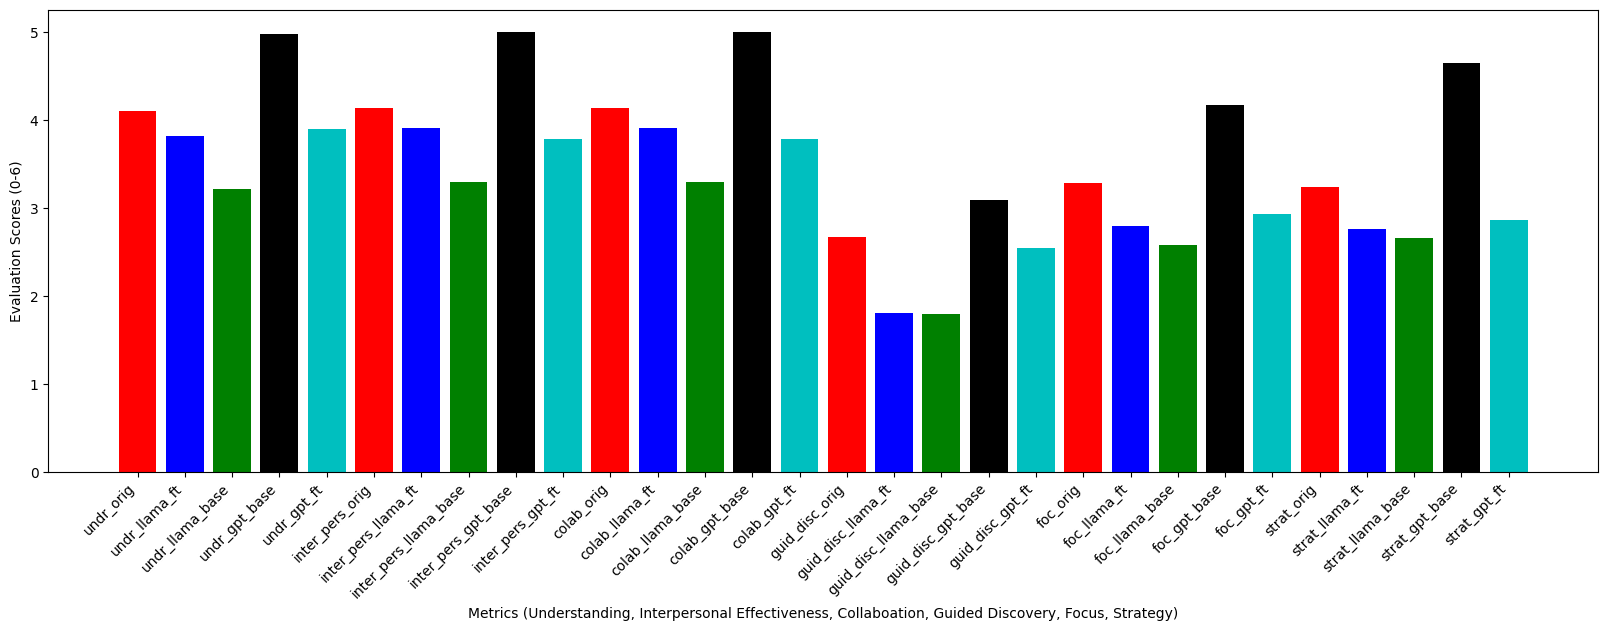

In [63]:
plt.figure(figsize=(20,6))
plt.bar(avg_metrics.index.to_list(), avg_metrics.values.tolist(), color=['r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metrics (Understanding, Interpersonal Effectiveness, Collaboation, Guided Discovery, Focus, Strategy)')
plt.ylabel('Evaluation Scores (0-6)')
plt.title('')
plt.show()

We can fine-tune the evaluator. Question/Answer and then we provide the rating (he issue is that A question related to Anxiety might be more popular than some other topics)

A pair-wise comparison could be better

At any time, we provide two answers (one with most votes, one with least votes). We tell them which one's better. We can use all the samples and make more pairs

For LLaMA and GPT, the length is affecting our results. So, we might want to restrict their length based on the average length of the answers in counselChat

THe bias in COunselChat could come from long answers by the evaluators or voters themselves. Maybe we can test out the length of the answers having high votes versus low votes

Print the average length of each of these